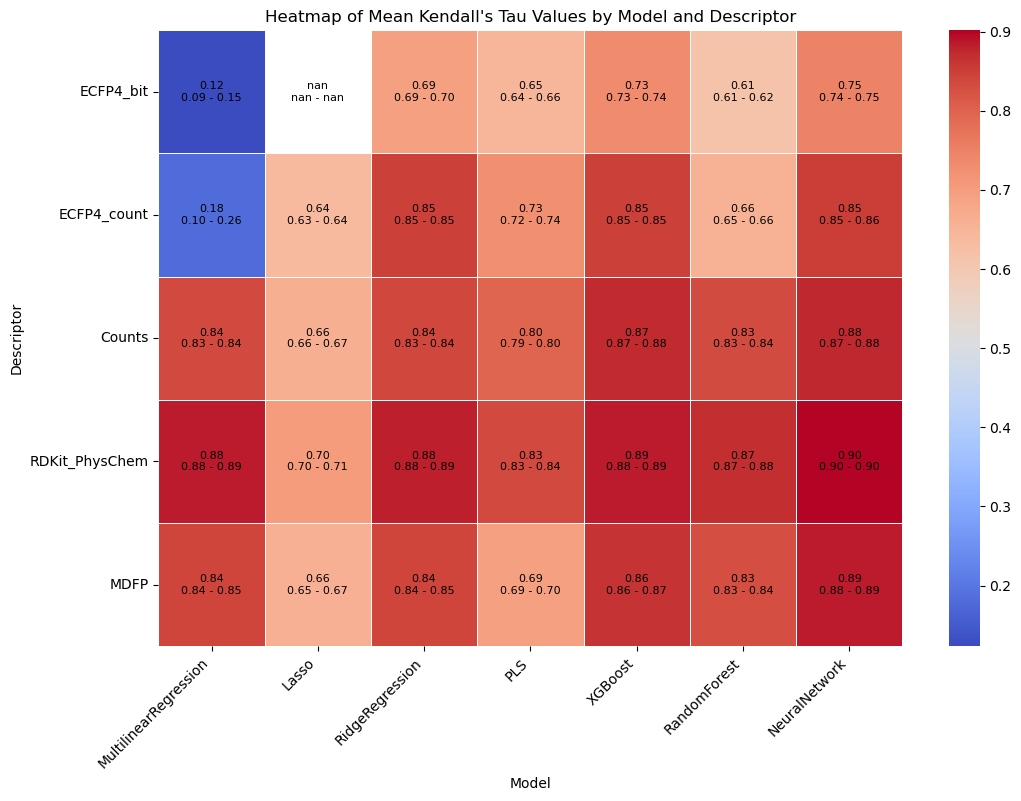

In [31]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_pickle('results/fragments_and_counts.pkl')

# Extract the relevant data
reals_list = data['reals_list']
predictions_list = data['predictions_list']
combined_titles = data['combined_titles']

# Calculate Kendall's tau for each combination
kendall_taus = []

for real, pred, title in zip(reals_list, predictions_list, combined_titles):
    taus = []
    for real_vals, pred_vals in zip(real, pred):
        tau, _ = stats.kendalltau(real_vals, pred_vals)
        taus.append(tau)
    kendall_taus.append(taus)

# Convert to DataFrame
df_kendall = pd.DataFrame(kendall_taus).T
df_kendall.columns = combined_titles

original_columns = df_kendall.columns

# Initialize lists to hold the data for the new DataFrame
models = []
descriptors = []
kendall_taus = []

# Loop through each column and split into model, descriptor, and append the data
for col in original_columns:
    model, descriptor = col.split(' (')
    descriptor = descriptor.rstrip(')')
    models.extend([model] * len(df_kendall))
    descriptors.extend([descriptor] * len(df_kendall))
    kendall_taus.extend(df_kendall[col].values)

# Create a new DataFrame with the three columns
new_df = pd.DataFrame({
    'Model': models,
    'Descriptor': descriptors,
    'KendallTau': kendall_taus
})


df_selection = new_df[new_df['Model'].isin(['XGBoost', 'PLS', 'Lasso', 'RandomForest', 'NeuralNetwork',
       'MultilinearRegression', 'RidgeRegression'])]
df_selection = df_selection[df_selection['Descriptor'].isin(['RDKit_PhysChem', 'MDFP', 
       'ECFP4_bit', 'ECFP4_count', 'Counts'])]

model_order = ['MultilinearRegression', 'Lasso', 'RidgeRegression', 'PLS', 'XGBoost', 'RandomForest', 'NeuralNetwork']
descriptor_order = ['ECFP4_bit', 'ECFP4_count', 'Counts', 'RDKit_PhysChem', 'MDFP']
grouped_df = df_selection.groupby(['Model', 'Descriptor']).agg(
    KendallTau_mean=('KendallTau', 'mean'),
    KendallTau_std=('KendallTau', 'std'),
    KendallTau_count=('KendallTau', 'count')
).reset_index()

# Convert the 'Model' and 'Descriptor' columns to categorical types with the defined order
grouped_df['Model'] = pd.Categorical(grouped_df['Model'], categories=model_order, ordered=True)
grouped_df['Descriptor'] = pd.Categorical(grouped_df['Descriptor'], categories=descriptor_order, ordered=True)

# Re-sort the DataFrame based on the new categorical order
grouped_df = grouped_df.sort_values(['Descriptor', 'Model'])
# Calculate the 90% confidence interval
grouped_df['KendallTau_CI'] = grouped_df.apply(
    lambda row: stats.norm.interval(0.90, loc=row['KendallTau_mean'], scale=row['KendallTau_std']/np.sqrt(row['KendallTau_count'])),
    axis=1
)

# Pivot the DataFrame again after sorting
heatmap_data = grouped_df.pivot(index="Descriptor", columns="Model", values="KendallTau_mean")

# Re-create the heatmap with sorted models and descriptors
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5, cbar=True)

plt.title("Heatmap of Mean Kendall's Tau Values by Model and Descriptor")
plt.xlabel("Model")
plt.ylabel("Descriptor")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add text boxes with the 90% CI
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        mean_val = heatmap_data.iloc[i, j]
        ci = grouped_df[(grouped_df['Descriptor'] == heatmap_data.index[i]) & 
                        (grouped_df['Model'] == heatmap_data.columns[j])]['KendallTau_CI'].values[0]
        ci_text = f"{ci[0]:.2f} - {ci[1]:.2f}"
        plt.text(j + 0.5, i + 0.5, f"{mean_val:.2f}\n{ci_text}",
                 ha='center', va='center', color='black', fontsize=8)

plt.show()



In [44]:
data.keys()

dict_keys(['reals_list', 'predictions_list', 'molregnos_list', 'combined_titles'])

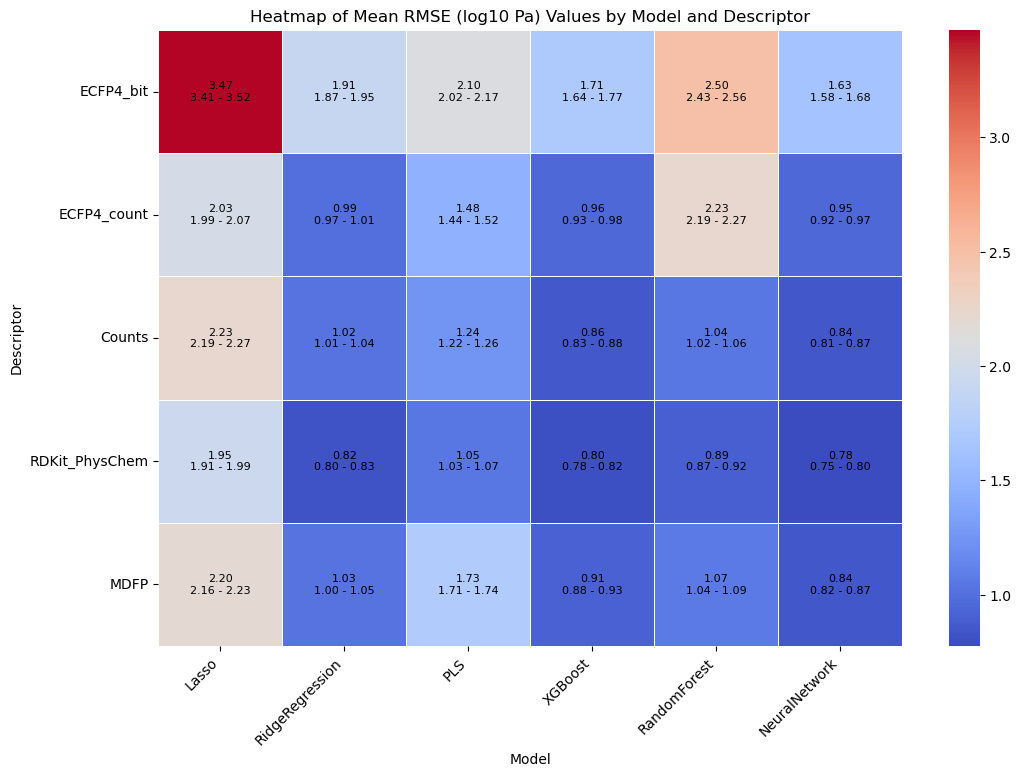

In [35]:
from sklearn.metrics import root_mean_squared_error  

data = pd.read_pickle('results/fragments_and_counts.pkl')

# Extract the relevant data
reals_list = data['reals_list']
predictions_list = data['predictions_list']
combined_titles = data['combined_titles']

# Calculate Kendall's tau for each combination
kendall_taus = []

for real, pred, title in zip(reals_list, predictions_list, combined_titles):
    taus = []
    for real_vals, pred_vals in zip(real, pred):
        tau = root_mean_squared_error(real_vals, pred_vals)
        taus.append(tau)
    kendall_taus.append(taus)

# Convert to DataFrame
df_kendall = pd.DataFrame(kendall_taus).T
df_kendall.columns = combined_titles

original_columns = df_kendall.columns

# Initialize lists to hold the data for the new DataFrame
models = []
descriptors = []
kendall_taus = []

# Loop through each column and split into model, descriptor, and append the data
for col in original_columns:
    model, descriptor = col.split(' (')
    descriptor = descriptor.rstrip(')')
    models.extend([model] * len(df_kendall))
    descriptors.extend([descriptor] * len(df_kendall))
    kendall_taus.extend(df_kendall[col].values)

# Create a new DataFrame with the three columns
new_df = pd.DataFrame({
    'Model': models,
    'Descriptor': descriptors,
    'KendallTau': kendall_taus
})


df_selection = new_df[new_df['Model'].isin(['XGBoost', 'PLS', 'Lasso', 'RandomForest', 'NeuralNetwork',
    'RidgeRegression'])]
df_selection = df_selection[df_selection['Descriptor'].isin(['RDKit_PhysChem', 'MDFP', 
       'ECFP4_bit', 'ECFP4_count', 'Counts'])]

model_order = ['Lasso', 'RidgeRegression', 'PLS', 'XGBoost', 'RandomForest', 'NeuralNetwork']
descriptor_order = ['ECFP4_bit', 'ECFP4_count', 'Counts', 'RDKit_PhysChem', 'MDFP']
grouped_df = df_selection.groupby(['Model', 'Descriptor']).agg(
    KendallTau_mean=('KendallTau', 'mean'),
    KendallTau_std=('KendallTau', 'std'),
    KendallTau_count=('KendallTau', 'count')
).reset_index()

# Convert the 'Model' and 'Descriptor' columns to categorical types with the defined order
grouped_df['Model'] = pd.Categorical(grouped_df['Model'], categories=model_order, ordered=True)
grouped_df['Descriptor'] = pd.Categorical(grouped_df['Descriptor'], categories=descriptor_order, ordered=True)

# Re-sort the DataFrame based on the new categorical order
grouped_df = grouped_df.sort_values(['Descriptor', 'Model'])
# Calculate the 90% confidence interval
grouped_df['KendallTau_CI'] = grouped_df.apply(
    lambda row: stats.norm.interval(0.90, loc=row['KendallTau_mean'], scale=row['KendallTau_std']/np.sqrt(row['KendallTau_count'])),
    axis=1
)

# Pivot the DataFrame again after sorting
heatmap_data = grouped_df.pivot(index="Descriptor", columns="Model", values="KendallTau_mean")

# Re-create the heatmap with sorted models and descriptors
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5, cbar=True)

plt.title("Heatmap of Mean RMSE (log10 Pa) Values by Model and Descriptor")
plt.xlabel("Model")
plt.ylabel("Descriptor")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add text boxes with the 90% CI
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        mean_val = heatmap_data.iloc[i, j]
        ci = grouped_df[(grouped_df['Descriptor'] == heatmap_data.index[i]) & 
                        (grouped_df['Model'] == heatmap_data.columns[j])]['KendallTau_CI'].values[0]
        ci_text = f"{ci[0]:.2f} - {ci[1]:.2f}"
        plt.text(j + 0.5, i + 0.5, f"{mean_val:.2f}\n{ci_text}",
                 ha='center', va='center', color='black', fontsize=8)

plt.show()

